In [1]:
import json
import pandas as pd

In [2]:
with open('results/2018-11-07-history.json', 'r') as f:
    history = json.load(f)

In [2]:
from sklearn.externals import joblib
with open("./results/2018-11-07-searches.joblib", "rb") as f:
    searches = joblib.load(f)

## Performance
`HyperbandCV` will find close to the best possible parameters with the given computational budget.*

<sup>* "will" := with high probability,
"close" := within log factors,
"best possible" in expected value.</sup>


In [3]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [4]:
medium_rare = [shape_history(hist, repeat=i, alg=k)
               for k, hists in history.items()
               for i, hist in enumerate(hists)
              ]

well_done = sum(medium_rare, [])

In [5]:
import pandas as pd
df = pd.DataFrame(well_done)
df.head(n=2)

,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,repeat
0,hyperband,0.762222,1,0.000000,0
1,hyperband,0.781111,2,0.000002,0


/Users/scott/anaconda3/envs/hyperband/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


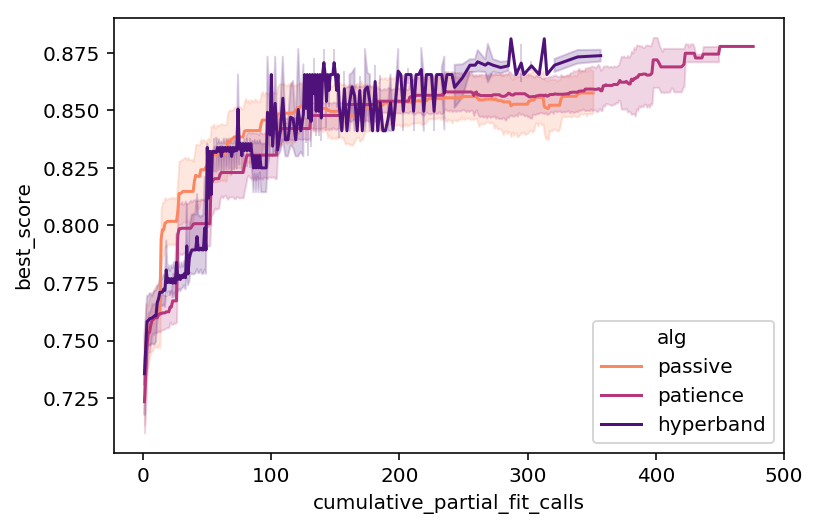

In [6]:
import seaborn as sns

adaptiveness = ["passive", "patience", "hyperband"]

sns.lineplot(
    data=df,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
    palette="magma_r",
)

/Users/scott/anaconda3/envs/hyperband/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


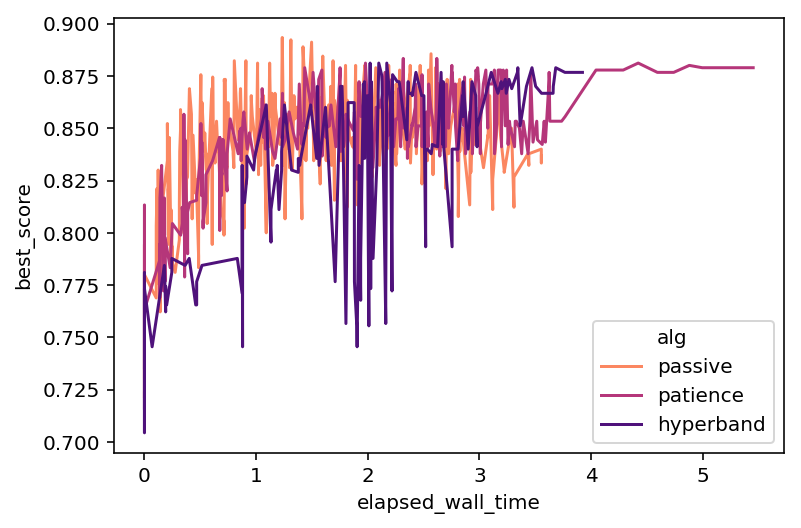

In [7]:
import seaborn as sns

sns.lineplot(
    data=df,
    x="elapsed_wall_time",
    y="best_score",
    hue="alg",
    hue_order=adaptiveness,
    palette="magma_r",
)

## Parameter visualization

In [22]:
with open("results/2018-11-07-cv_results.json", "r") as f:
    cv_results = json.load(f)

In [24]:
results = {k: [result[k] for result in cv_results["passive"]]
              for k in cv_results["passive"][0]}
results = {k: sum(v, []) for k, v in results.items()}

In [30]:
import numpy as np
hist = pd.DataFrame(results)
hist.head()

#hist['param_optimizer_'] = hist['param_optimizer'].apply(lambda opt: str(opt).replace('<class', '').strip('>'))
hist['test_loss'] = -1 * hist['test_score']
hist = hist.sort_values(by='test_loss')
hist['rank'] = np.arange(len(hist)) + 1
hist.head()

,mean_partial_fit_time,mean_score_time,std_partial_fit_time,std_score_time,test_score,model_id,params,partial_fit_calls,param_alpha,rank_test_score,test_loss,rank
118,0.003800,0.004351,0.001258,0.003586,0.885556,1,{'alpha': 0.45810882802849434},27,0.458109,1,-0.885556,1
120,0.003660,0.002615,0.001334,0.001122,0.883333,3,{'alpha': 0.336849981189392},27,0.336850,2,-0.883333,2
123,0.003825,0.003526,0.001096,0.002458,0.880000,6,{'alpha': 0.39624299533109036},27,0.396243,3,-0.880000,3
7,0.003559,0.004686,0.001268,0.003629,0.873333,7,{'alpha': 0.07378938113890329},27,0.073789,1,-0.873333,4
48,0.003736,0.003592,0.001252,0.002175,0.868889,9,{'alpha': 0.41084368289362944},27,0.410844,1,-0.868889,5


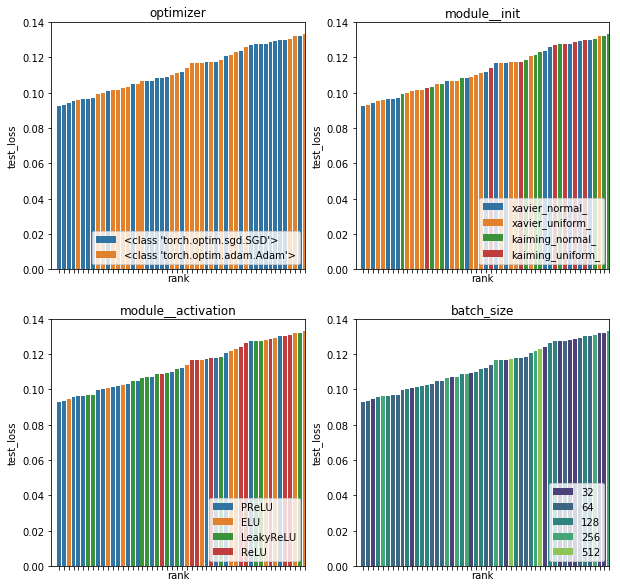

In [109]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
hues = ['param_optimizer', 'param_module__init', 'param_module__activation', 'param_batch_size']
for ax, hue in zip(axs, hues):
    cmap = None
    if 'batch_size' in hue:
        cmap = 'viridis'
    sns.barplot(
        x='rank', 
        y='test_loss',
        hue=hue,
        data=hist,
        ax=ax,
        palette=cmap,
        dodge=False,
    )
    ax.set_xlim(-1.5, 50)
    ax.set_ylim(0, 0.14)
    ax.grid(linestyle='--', which='y')
    ax.legend(loc='lower right')
    ax.set_title(hue.replace('param_', ''))
    ax.tick_params(labelbottom=False)
plt.show()

In [63]:
sgd_alg = [a for a in hist.param_optimizer_.unique() if 'sgd' in a.lower()][0]
sgd = hist[hist.param_optimizer_ == sgd_alg]

[" 'torch.optim.sgd.SGD'"]


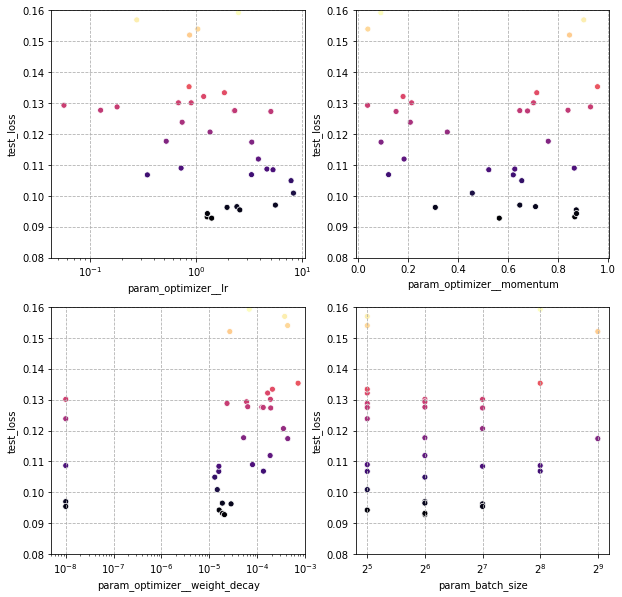

In [108]:
w = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*w, 2*w))
axs = axs.flat[:]
variables = ['param_optimizer__lr', 'param_optimizer__momentum', 'param_optimizer__weight_decay', 'param_batch_size']
print(sgd.param_optimizer_.unique())
for ax, var in zip(axs, variables):
    show = sgd.copy()
    show = show.sort_values(by=var)
    if 'weight_decay' in var:
        show[var] += 1e-8
    show = show[show.test_loss < 0.16]
    sns.scatterplot(
        x=var,
        y='test_loss',
        data=show,
        hue='test_loss',
        palette='magma',
        legend=False,
        ax=ax,
    )
    if 'lr' in var:
        ax.set_xscale('log', basex=10)
    if 'batch_size' in var:
        ax.set_xscale('log', basex=2)
    if 'weight_decay' in var:
        ax.set_xlim(5e-9, 1e-3)
        ax.set_xscale('log', basex=10)
    
    ax.grid(linestyle='--')
    ax.set_ylim(0.08, 0.16)
plt.show()